In [80]:
from datetime import date
import json
import pandas as pd

with open("../chat_history_tfidf.json") as f:
    data = json.load(f)
    tdf = pd.json_normalize(data)
    tdf["test_name"] = "tfidf"

with open("../chat_history_semantic_search.json") as f:
    data = json.load(f)
    sdf = pd.json_normalize(data)
    sdf["test_name"] = "semantic_search"

with open("../chat_history_semantic_search_variable.json") as f:
    data = json.load(f)
    vdf = pd.json_normalize(data)
    vdf["test_name"] = "semantic_search_variable"


df = pd.concat([sdf, tdf, vdf], ignore_index=True)


df['gpu_energy.joules'] = df['gpu_energy'] * 3600000
df['gpu_energy.request'] = df['gpu_energy.joules'] / 100
df = df.loc[~df.debug_mode]

df = df[df["model"] == "mistralai/Mistral-Small-3.1-24B-Instruct-2503"]
mrcr = df[df["name"] == "MRCR"]
mc = df[df["name"] == "multi-challenge"].copy()
mc['score'] = mc['score'] / 100

In [81]:
from matplotlib import pyplot as plt
import numpy as np

def score_plot(test_names, test_names_nice, benchmark_name, df, colors = ['green', 'blue'], energy=False):
    # Create a figure with 3 subplots arranged horizontally
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

    y_max = float('-inf')
    # Plot each test in its own subplot
    for i, test_name in enumerate(test_names):
        # Filter data for this test
        test_data = df[df['test_name'] == test_name]

        test_data = test_data.reset_index()
        test_data = test_data.drop_duplicates(subset='sensitivity', keep='first')
        test_data = test_data.set_index('sensitivity')

        y_max = max(y_max, test_data['score'].max())
        y = 'score'
        if energy:
            y = "gpu_energy.joules"

        # Plot on the corresponding axis
        test_data.plot(
            y=y,
            ax=axes[i],
            style='.-',
            color=colors[i],
            legend=False
        )

        # Set x-ticks and labels
        x = [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
        axes[i].set_xticks(x)
        axes[i].set_xticklabels([f'{int(val*100)}%' for val in x])

        # Set title for each subplot
        axes[i].set_title(f'{test_names_nice[i]}')

        # Set x-label
        axes[i].set_xlabel('Amount of retained messages (%)')

    y_max = min(1, y_max * 1.05)  # Don't go above 1



    if energy:
        axes[0].set_ylabel(f'GPU energy (Joules)')
        fig.suptitle(f'{benchmark_name} GPU energy consumption with different message reduction techniques', fontsize=16)

    else:
        for ax in axes:
            ax.set_ylim(0, y_max)
        y_ticks = np.arange(0, y_max + 0.01, 0.1)
        y_ticks = y_ticks[y_ticks <= y_max]
        # Apply y-ticks to all subplots
        for ax in axes:
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{int(val * 100)}%' for val in y_ticks])


        # Set common y-label on the left subplot only
        axes[0].set_ylabel(f'{benchmark_name} score')

        # Add a main title for the entire figure
        fig.suptitle(f'{benchmark_name} score with different message reduction techniques', fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Make room for the subtitle

    plt.show()

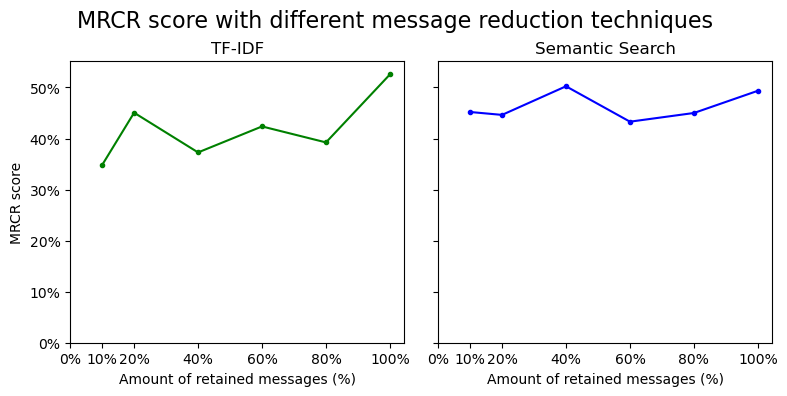

In [82]:
test_names = ["tfidf", "semantic_search"]
test_names_nice = ["TF-IDF", "Semantic Search"]
benchmark_name = "MRCR"
score_plot(test_names, test_names_nice, benchmark_name, mrcr)

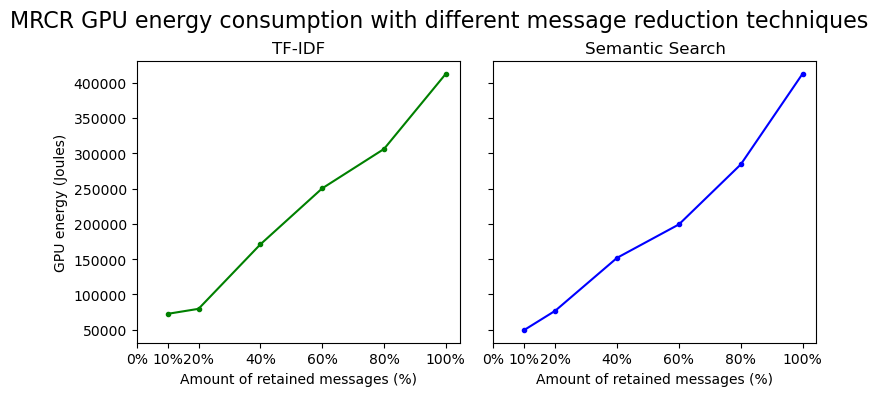

In [83]:
test_names = ["tfidf", "semantic_search"]
test_names_nice = ["TF-IDF", "Semantic Search"]
benchmark_name = "MRCR"
score_plot(test_names, test_names_nice, benchmark_name, mrcr, energy=True)


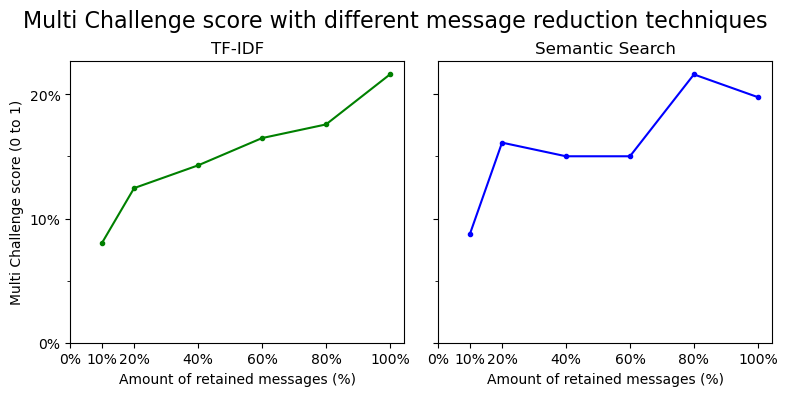

In [61]:
test_names = ["tfidf", "semantic_search"]
test_names_nice = ["TF-IDF", "Semantic Search"]
benchmark_name = "Multi Challenge"
score_plot(test_names, test_names_nice, benchmark_name, mc)

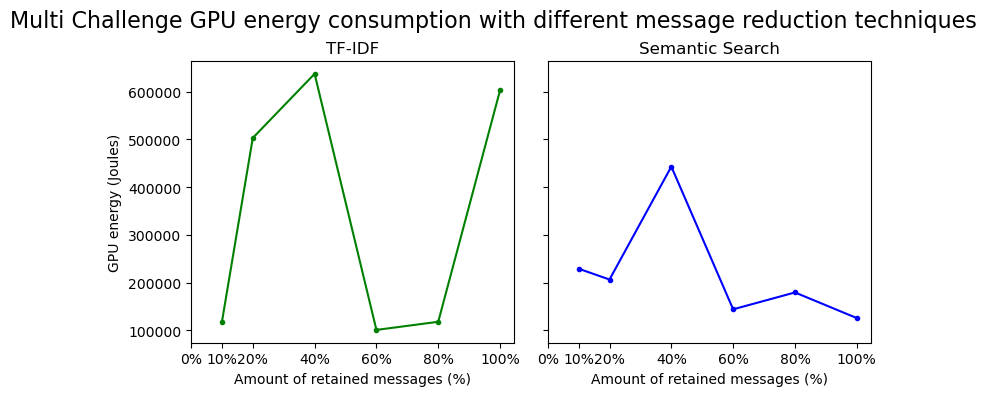

In [84]:
test_names = ["tfidf", "semantic_search"]
test_names_nice = ["TF-IDF", "Semantic Search"]
benchmark_name = "Multi Challenge"
score_plot(test_names, test_names_nice, benchmark_name, mc, energy=True)

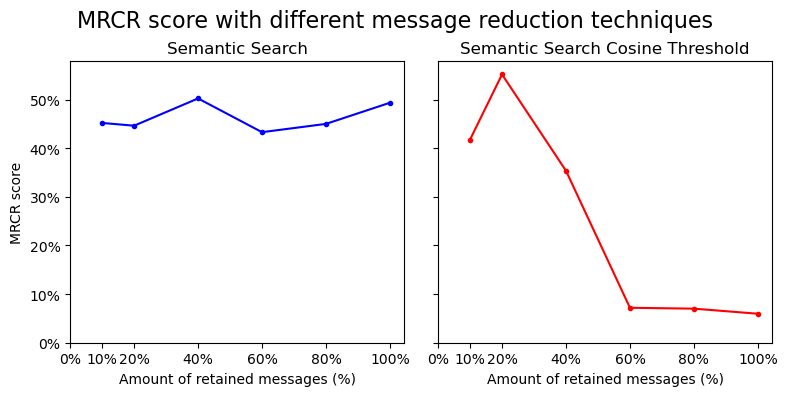

In [85]:
test_names = ["semantic_search", "semantic_search_variable"]
test_names_nice = ["Semantic Search", "Semantic Search Cosine Threshold"]
benchmark_name = "MRCR"
score_plot(test_names, test_names_nice, benchmark_name, mrcr, ["blue", "red"])


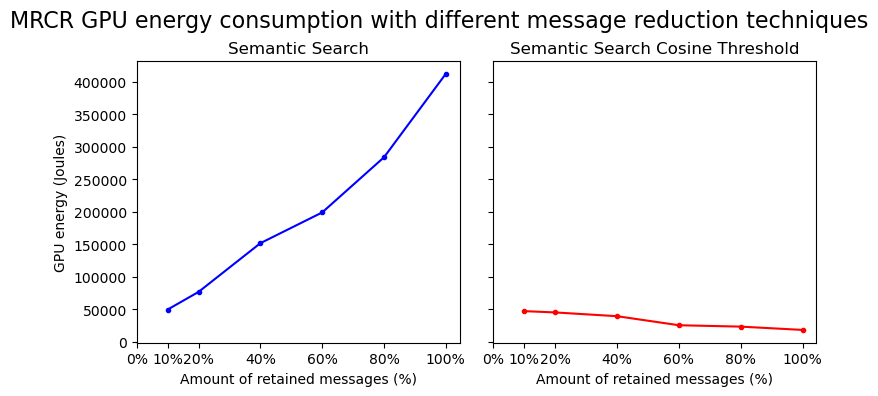

In [86]:
test_names = ["semantic_search", "semantic_search_variable"]
test_names_nice = ["Semantic Search", "Semantic Search Cosine Threshold"]
benchmark_name = "MRCR"
score_plot(test_names, test_names_nice, benchmark_name, mrcr, ["blue", "red"], energy=True)


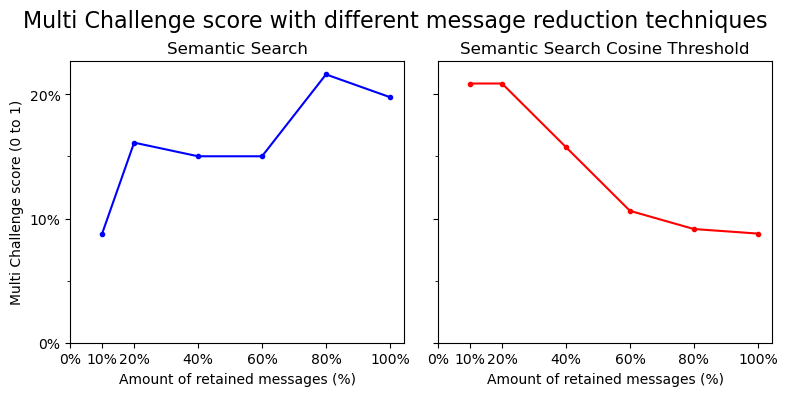

In [69]:
test_names = ["semantic_search", "semantic_search_variable"]
test_names_nice = ["Semantic Search", "Semantic Search Cosine Threshold"]
benchmark_name = "Multi Challenge"
score_plot(test_names, test_names_nice, benchmark_name, mc, ["blue", "red"])

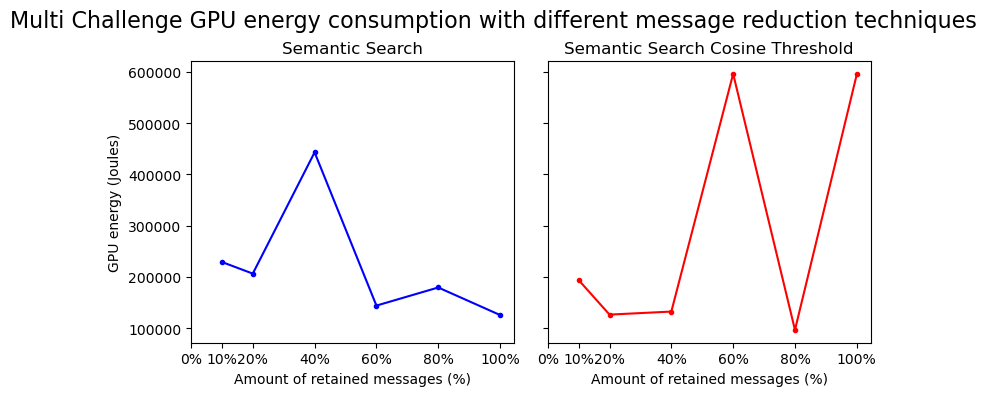

In [88]:
test_names = ["semantic_search", "semantic_search_variable"]
test_names_nice = ["Semantic Search", "Semantic Search Cosine Threshold"]
benchmark_name = "Multi Challenge"
score_plot(test_names, test_names_nice, benchmark_name, mc, ["blue", "red"], energy=True)

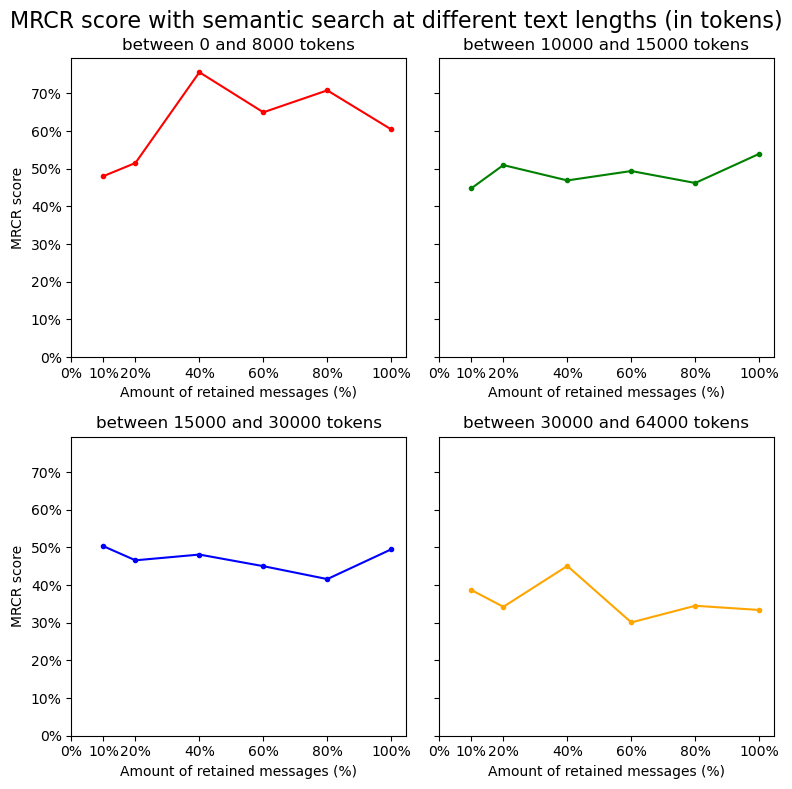

In [26]:
import numpy as np
from matplotlib import pyplot as plt

# Create a figure with 4 subplots arranged in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharey=True)
# Flatten the 2D array of axes for easier indexing
axes = axes.flatten()

# Get unique test names and sort them numerically
test_names = sorted(mrcr['config.info.max_tokens'].unique(), key=float)
min_names = sorted(mrcr['config.info.min_tokens'].unique(), key=float)

colors = ['red', 'green', 'blue', 'orange']  # Reordered to match the sorted test names
y_max = float('-inf')

# Plot each test in its own subplot
for i, test_name in enumerate(test_names):
    # Filter data for this test
    test_data = mrcr[mrcr['config.info.max_tokens'] == test_name].copy()

    # Since sensitivity is the index, we need to handle duplicates at the index level
    # For each sensitivity value, keep only the most recent entry
    # Reset index to make sensitivity a column, then drop duplicates, then set index back
    test_data = test_data.reset_index()
    test_data = test_data.drop_duplicates(subset='sensitivity', keep='last')
    test_data = test_data.set_index('sensitivity')

    # Sort by index to ensure proper line connection
    test_data = test_data.sort_index()

    y_max = max(y_max, test_data['score'].max())

    # Plot on the corresponding axis
    test_data.plot(
        y='score',
        ax=axes[i],
        style='.-',
        color=colors[i],
        legend=False
    )

    # Set x-ticks and labels
    x = [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
    axes[i].set_xticks(x)
    axes[i].set_xticklabels([f'{int(val * 100)}%' for val in x])

    y_ticks = axes[i].get_yticks()
    axes[i].set_yticks(y_ticks)
    axes[i].set_yticklabels([f'{int(val * 100)}%' for val in y_ticks])
    # Set title for each subplot
    axes[i].set_title(f'between {int(min_names[i])} and {int(test_name)} tokens')

    # Set x-label
    axes[i].set_xlabel('Amount of retained messages (%)')

y_max = min(1, y_max * 1.05)  # Don't go above 1

# Set consistent y-limits for all subplots
for ax in axes:
    ax.set_ylim(0, y_max)

# Create nice y-ticks that are multiples of 0.1 (10%)
y_ticks = np.arange(0, y_max + 0.01, 0.1)
y_ticks = y_ticks[y_ticks <= y_max]
# Apply y-ticks to all subplots
for ax in axes:
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{int(val * 100)}%' for val in y_ticks])

# Set y-labels for the left subplots
axes[0].set_ylabel('MRCR score')
axes[2].set_ylabel('MRCR score')

# Add a main title for the entire figure
fig.suptitle('MRCR score with semantic search at different text lengths (in tokens)', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Make room for the subtitle

plt.show()